In [1]:
import gzip
import xml.etree.ElementTree as ET
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd
from pyproj import CRS
from tqdm import tqdm
import matplotlib.pyplot as plt

# Extract Bike Trips from Events File

Processing events: 29819541it [00:41, 723346.94it/s]
Processing network: 5090519it [00:12, 415762.17it/s]
C:\Users\omkarp\AppData\Local\Temp\ipykernel_17788\3329914684.py:120: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


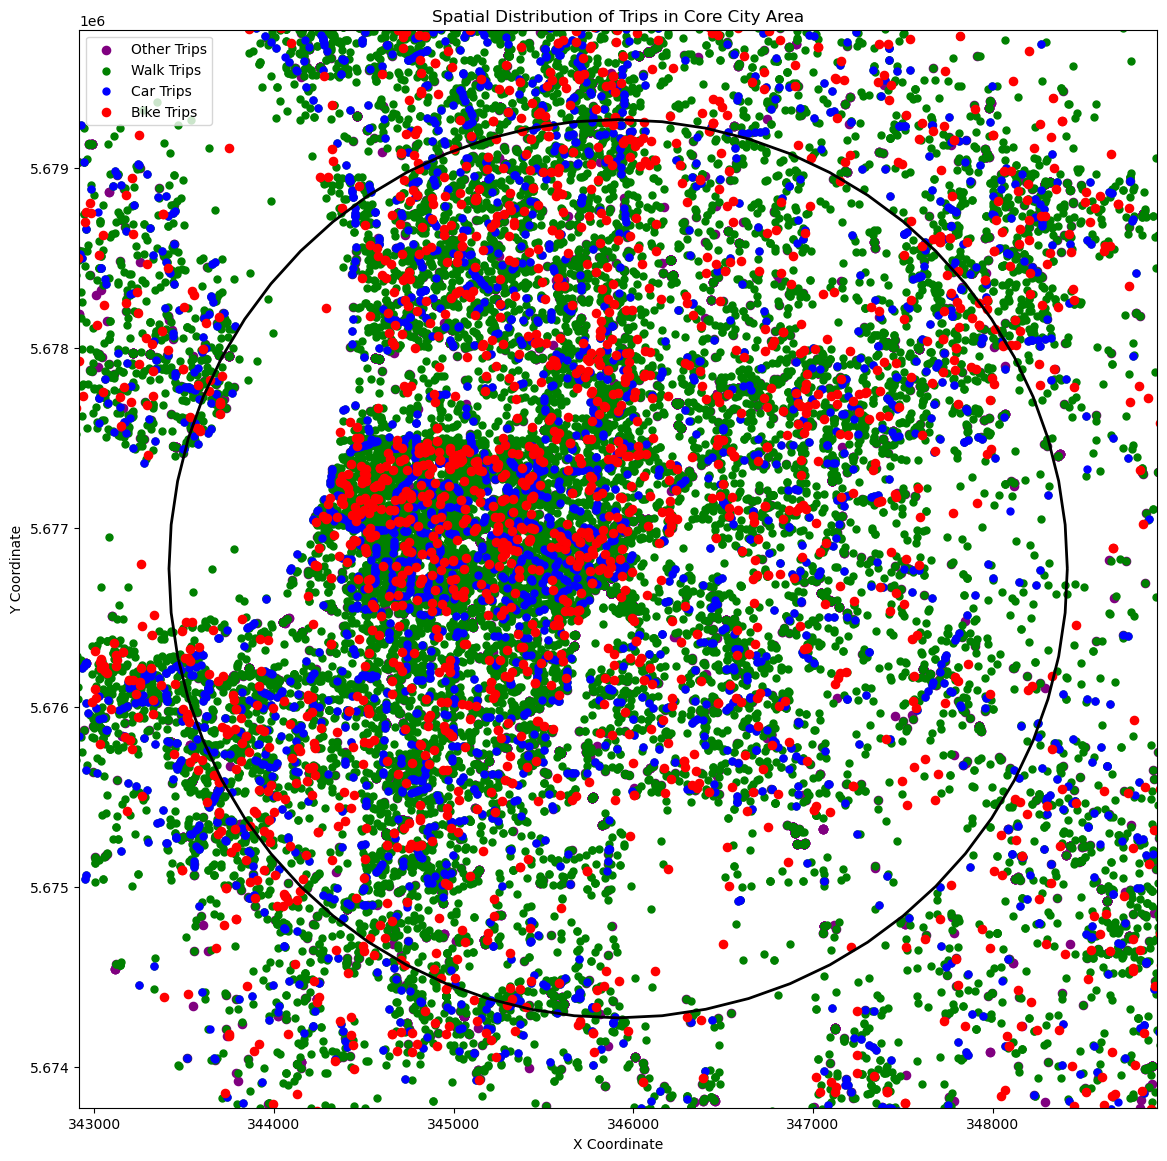

In [2]:
events_file = 'duesseldorf-1pct-dc_114.output_events.xml.gz'
network_file = 'duesseldorf-1pct-dc_114.output_network.xml.gz'

person_coords = {}
bike_trips = []
walk_trips = []
car_trips = []
other_trips = []

def parse_events(file):
    with gzip.open(file, 'rb') as f:
        context = ET.iterparse(f, events=("start", "end"))
        context = iter(context)
        event, root = next(context)
        
        for event, elem in tqdm(context, desc='Processing events'):
            if event == 'end':
                if elem.tag == 'event' and elem.get('type') == 'actend':
                    person_id = elem.get('person')
                    x = float(elem.get('x'))
                    y = float(elem.get('y'))
                    person_coords[person_id] = (x, y)
                
                elif elem.tag == 'event' and elem.get('type') == 'departure':
                    time = float(elem.get('time'))
                    link_id = elem.get('link')
                    person_id = elem.get('person')
                    mode = elem.get('legMode')
                    if person_id in person_coords:
                        x, y = person_coords[person_id]
                        if mode == 'bike':
                            bike_trips.append({'time': time, 'link_id': link_id, 'x': x, 'y': y, 'mode': mode})
                        elif mode == 'walk':
                            walk_trips.append({'time': time, 'link_id': link_id, 'x': x, 'y': y, 'mode': mode})
                        elif mode == 'car':
                            car_trips.append({'time': time, 'link_id': link_id, 'x': x, 'y': y, 'mode': mode})
                        else:
                            other_trips.append({'time': time, 'link_id': link_id, 'x': x, 'y': y, 'mode': mode})
                
                # Clear the element to free memory
                elem.clear()
                root.clear()

parse_events(events_file)

bike_trips_df = pd.DataFrame(bike_trips)
walk_trips_df = pd.DataFrame(walk_trips)
car_trips_df = pd.DataFrame(car_trips)
other_trips_df = pd.DataFrame(other_trips)

def trips_to_gdf(trips_df):
    geometry = [Point(xy) for xy in zip(trips_df['x'], trips_df['y'])]
    gdf = gpd.GeoDataFrame(trips_df, geometry=geometry)
    gdf.crs = CRS.from_epsg(25832)
    return gdf

bike_trips_gdf = trips_to_gdf(bike_trips_df)
walk_trips_gdf = trips_to_gdf(walk_trips_df)
car_trips_gdf = trips_to_gdf(car_trips_df)
other_trips_gdf = trips_to_gdf(other_trips_df)

CENTER_X = 345916.350
CENTER_Y = 5676770.602
RADIUS = 2500.0  # 5 km diameter
city_center = Point(CENTER_X, CENTER_Y)
core_city_area = city_center.buffer(RADIUS)

links = []

with gzip.open(network_file, 'rb') as f:
    context = ET.iterparse(f, events=("start", "end"))
    context = iter(context)
    event, root = next(context)
    
    for event, elem in tqdm(context, desc='Processing network'):
        if event == 'end' and elem.tag == 'link':
            link_id = elem.get('id')
            from_node = elem.get('from')
            to_node = elem.get('to')
            from_coord = None
            to_coord = None
            for node in root.findall(f".//node[@id='{from_node}']"):
                from_coord = (float(node.get('x')), float(node.get('y')))
            for node in root.findall(f".//node[@id='{to_node}']"):
                to_coord = (float(node.get('x')), float(node.get('y')))
            if from_coord and to_coord:
                links.append({'link_id': link_id, 'geometry': LineString([from_coord, to_coord])})
                
            # Clear the element to free memory
            elem.clear()
            root.clear()

links_gdf = gpd.GeoDataFrame(links)
links_gdf.crs = CRS.from_epsg(25832)

fig, ax = plt.subplots(figsize=(14, 14))
other_trips_gdf.plot(ax=ax, color='purple',  markersize=35, label='Other Trips', marker='o', linestyle='None')
walk_trips_gdf.plot(ax=ax, color='green',  markersize=25, label='Walk Trips', marker='o', linestyle='None')
car_trips_gdf.plot(ax=ax, color='blue',  markersize=25, label='Car Trips', marker='o', linestyle='None')
bike_trips_gdf.plot(ax=ax, color='red',  markersize=35, label='Bike Trips', marker='o', linestyle='None')
gpd.GeoSeries([core_city_area]).plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='Core City Area')


xmin, ymin, xmax, ymax = core_city_area.bounds
buffer = 500  # Add some buffer to the view
ax.set_xlim(xmin-buffer, xmax+buffer)
ax.set_ylim(ymin-buffer, ymax+buffer)

plt.legend()
plt.title('Spatial Distribution of Trips in Core City Area')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.savefig('After_Scenario.png')
plt.show()

In [3]:
# Summary statistics
total_bike_trips = len(bike_trips_gdf)
total_walk_trips = len(walk_trips_gdf)
total_car_trips = len(car_trips_gdf)
total_other_trips = len(other_trips_gdf)
print(f"Total number of bike trips in the core city area: {total_bike_trips}")
print(f"Total number of walk trips in the core city area: {total_walk_trips}")
print(f"Total number of car trips in the core city area: {total_car_trips}")
print(f"Total number of other trips in the core city area: {total_other_trips}")

Total number of bike trips in the core city area: 4292
Total number of walk trips in the core city area: 85416
Total number of car trips in the core city area: 13134
Total number of other trips in the core city area: 31422


# Before scenario implementation

Processing plans: 472553it [00:00, 896683.47it/s]


Captured 1587 bike points, 6959 walk points, 9962 car points, and 26712 other points.


Processing network: 4231243it [00:10, 391479.11it/s]
C:\Users\omkarp\AppData\Local\Temp\ipykernel_17788\341461975.py:131: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


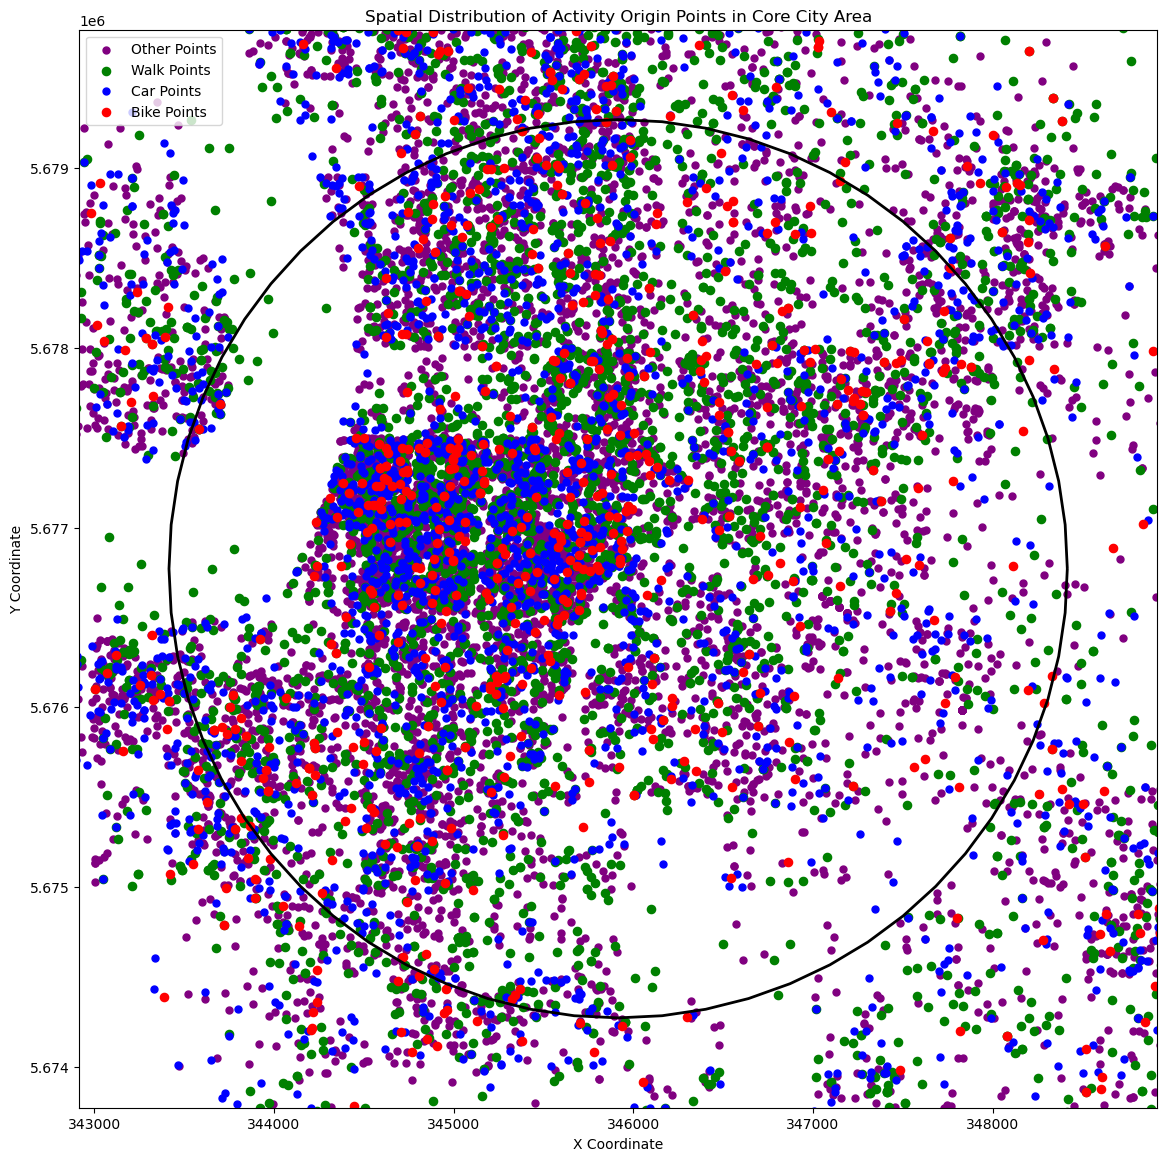

In [4]:
plans_file = 'duesseldorf-v1.7-1pct.plans.xml.gz'
network_file = 'duesseldorf-v1.7-network-with-pt.xml.gz'

# Initialize lists to store activity data for different modes
bike_points = []
walk_points = []
car_points = []
other_points = []

# Function to parse the plans file
def parse_plans(file):
    with gzip.open(file, 'rb') as f:
        context = ET.iterparse(f, events=("start", "end"))
        context = iter(context)
        event, root = next(context)
        
        current_mode = None

        for event, elem in tqdm(context, desc='Processing plans'):
            if event == 'end':
                if elem.tag == 'person':
                    current_mode = None  # Reset mode for each person
                
                elif elem.tag == 'activity':
                    x = elem.get('x')
                    y = elem.get('y')
                    if x is not None and y is not None and current_mode is not None:
                        point = {
                            'mode': current_mode,
                            'x': float(x),
                            'y': float(y)
                        }
                        if current_mode == 'bike':
                            bike_points.append(point)
                        elif current_mode == 'walk':
                            walk_points.append(point)
                        elif current_mode == 'car':
                            car_points.append(point)
                        else:
                            other_points.append(point)
                
                elif elem.tag == 'leg':
                    current_mode = elem.get('mode')

                # Clear the element to free memory
                elem.clear()
                root.clear()

    print(f"Captured {len(bike_points)} bike points, {len(walk_points)} walk points, {len(car_points)} car points, and {len(other_points)} other points.")

# Parse the plans file
parse_plans(plans_file)

# Convert to GeoDataFrames
def points_to_gdf(points):
    if not points:
        return gpd.GeoDataFrame()
    geometry = [Point(point['x'], point['y']) for point in points]
    df = pd.DataFrame(points)
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf.crs = CRS.from_epsg(25832)
    return gdf

bike_points_gdf = points_to_gdf(bike_points)
walk_points_gdf = points_to_gdf(walk_points)
car_points_gdf = points_to_gdf(car_points)
other_points_gdf = points_to_gdf(other_points)

# Define the city center and radius
CENTER_X = 345916.350
CENTER_Y = 5676770.602
RADIUS = 2500.0  # 5 km diameter
city_center = Point(CENTER_X, CENTER_Y)
core_city_area = city_center.buffer(RADIUS)

# Parse the network file
def parse_network(file):
    links = []
    with gzip.open(file, 'rb') as f:
        context = ET.iterparse(f, events=("start", "end"))
        context = iter(context)
        event, root = next(context)

        for event, elem in tqdm(context, desc='Processing network'):
            if event == 'end' and elem.tag == 'link':
                link_id = elem.get('id')
                from_node = elem.get('from')
                to_node = elem.get('to')
                from_coord = None
                to_coord = None
                for node in root.findall(f".//node[@id='{from_node}']"):
                    from_coord = (float(node.get('x')), float(node.get('y')))
                for node in root.findall(f".//node[@id='{to_node}']"):
                    to_coord = (float(node.get('x')), float(node.get('y')))
                if from_coord and to_coord:
                    links.append({'link_id': link_id, 'geometry': LineString([from_coord, to_coord])})

                # Clear the element to free memory
                elem.clear()
                root.clear()
    return links

links = parse_network(network_file)

# Convert links to GeoDataFrame
links_gdf = gpd.GeoDataFrame(links)
links_gdf.crs = CRS.from_epsg(25832)

# Plot the trips and network
fig, ax = plt.subplots(figsize=(14, 14))
# links_gdf.plot(ax=ax, color='gray', linewidth=0.5, label='Network Links')
if not other_points_gdf.empty:
    other_points_gdf.plot(ax=ax, color='purple', markersize=25, label='Other Points', marker='o', linestyle='None')
    
if not walk_points_gdf.empty:
    walk_points_gdf.plot(ax=ax, color='green', markersize=35, label='Walk Points', marker='o', linestyle='None')
    
if not car_points_gdf.empty:
    car_points_gdf.plot(ax=ax, color='blue', markersize=25, label='Car Points', marker='o', linestyle='None')
    
if not bike_points_gdf.empty:
    bike_points_gdf.plot(ax=ax, color='red', markersize=35, label='Bike Points', marker='o', linestyle='None')
gpd.GeoSeries([core_city_area]).plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='Core City Area')

# Zoom to the core city area but show outer trips as well
xmin, ymin, xmax, ymax = core_city_area.bounds
buffer = 500  # Add some buffer to the view
ax.set_xlim(xmin-buffer, xmax+buffer)
ax.set_ylim(ymin-buffer, ymax+buffer)

plt.legend()
plt.title('Spatial Distribution of Activity Origin Points in Core City Area')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.savefig('Before_Scenario.png')
plt.show()

In [5]:
# Summary statistics
total_bike_trips = len(bike_trips_gdf)
total_walk_trips = len(walk_trips_gdf)
total_car_trips = len(car_trips_gdf)
total_other_trips = len(other_trips_gdf)
print(f"Total number of bike trips in the core city area: {total_bike_trips}")
print(f"Total number of walk trips in the core city area: {total_walk_trips}")
print(f"Total number of car trips in the core city area: {total_car_trips}")
print(f"Total number of other trips in the core city area: {total_other_trips}")

Total number of bike trips in the core city area: 4292
Total number of walk trips in the core city area: 85416
Total number of car trips in the core city area: 13134
Total number of other trips in the core city area: 31422


Output counts: {'bike': 4292, 'walk': 85416, 'car': 13134, 'other': 31422}
Scaled input counts: {'bike': 4642, 'walk': 25335, 'car': 30440, 'other': 73847}


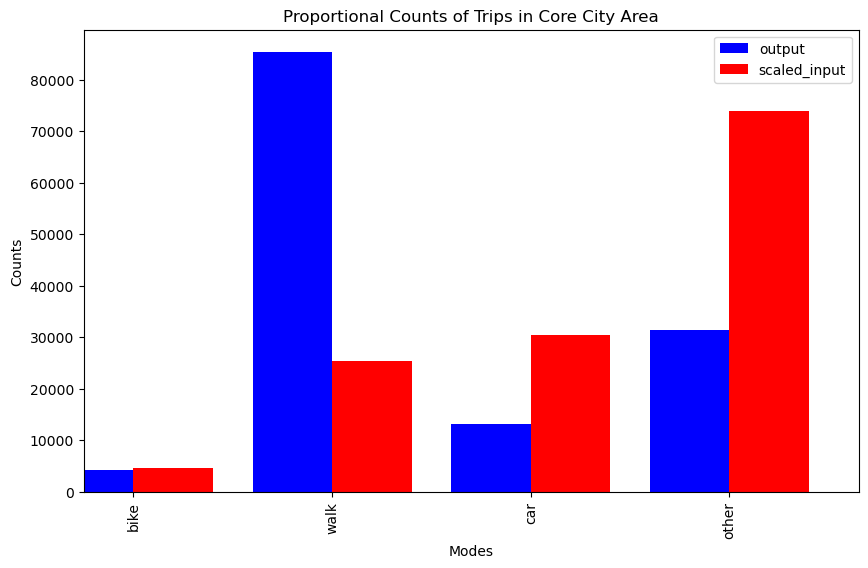

In [6]:
output_counts = {
    'bike': 4292,
    'walk': 85416,
    'car': 13134,
    'other': 31422
}

input_counts = {
    'bike': 1109,
    'walk': 6051,
    'car': 7271,
    'other': 17639
}

# Calculate total counts
total_output = sum(output_counts.values())
total_input = sum(input_counts.values())

# Calculate scaling factor
scaling_factor = total_output / total_input

# Apply scaling factor to input counts
scaled_input_counts = {mode: int(count * scaling_factor) for mode, count in input_counts.items()}

# Ensure the total counts match by adjusting the largest category (walk trips)
difference = total_output - sum(scaled_input_counts.values())
scaled_input_counts['walk'] += difference

# Display the scaled counts
print("Output counts:", output_counts)
print("Scaled input counts:", scaled_input_counts)

# Prepare data for visualization
output_counts_df = pd.DataFrame.from_dict(output_counts, orient='index', columns=['output'])
scaled_input_counts_df = pd.DataFrame.from_dict(scaled_input_counts, orient='index', columns=['scaled_input'])

# Plot the counts
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
output_counts_df.plot(kind='bar', ax=ax, color='blue', position=1, width=0.4, label='Output Counts')
scaled_input_counts_df.plot(kind='bar', ax=ax, color='red', position=0, width=0.4, label='Scaled Input Counts')
plt.legend()
plt.title('Proportional Counts of Trips in Core City Area')
plt.xlabel('Modes')
plt.ylabel('Counts')
plt.show()